In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [98]:
df = pd.read_csv("/content/BNB-USD.csv")

In [99]:
# Kiểm tra dữ liệu
print(df.head())
print(df.info())

         Date       Open       High        Low      Close  Adj Close  \
0  2019-03-01  10.356931  11.607489  10.325634  11.393217  11.393217   
1  2019-03-02  11.384693  11.915753  10.960816  11.869744  11.869744   
2  2019-03-03  11.845305  11.964979  11.352064  11.537903  11.537903   
3  2019-03-04  11.538013  11.599405  11.070543  11.545945  11.545945   
4  2019-03-05  11.520388  13.841443  11.520388  13.811967  13.811967   

      Volume  
0  117838677  
1  120807894  
2   89868246  
3   89421231  
4  237026335  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1828 non-null   object 
 1   Open       1828 non-null   float64
 2   High       1828 non-null   float64
 3   Low        1828 non-null   float64
 4   Close      1828 non-null   float64
 5   Adj Close  1828 non-null   float64
 6   Volume     1828 non-null   int64  
dtypes: flo

In [100]:
# Sử dụng cột 'Close' làm dữ liệu để dự đoán
df1 = df['Close'].values.reshape(-1, 1)

In [101]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [102]:
# Chia dữ liệu thành tập train và test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [103]:
# Kiểm tra kích thước của tập train và test
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1279
Test data size: 549


In [104]:
# Hàm tạo dataset từ chuỗi dữ liệu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [105]:
# Tạo các tập X và Y từ dữ liệu train và test
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [106]:
# Định hình lại dữ liệu để phù hợp với đầu vào của TimesNet
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [107]:
# Xây dựng mô hình TimesNet
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [108]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
19/19 [==============================] - 1s 15ms/step - loss: 0.0282
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0057
Epoch 3/100
19/19 [==============================] - 0s 15ms/step - loss: 0.0036
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 5/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0022
Epoch 6/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0021
Epoch 7/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 8/100
19/19 [==============================] - 0s 15ms/step - loss: 0.0016
Epoch 9/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 10/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0013
Epoch 11/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0012
Epoch 12/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 13/100
19/19 [=====

In [109]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

14/14 [==============================] - 0s 4ms/step


In [110]:
# Chuyển đổi giá trị về phạm vi gốc
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [111]:
# Đánh giá mô hình
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mse = np.mean((y_test - test_predict)**2)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test MSE:', test_mse)

Train RMSE: 12.103383817585652
Test RMSE: 9.230951993821535
Test MAPE: 2.4231943856912244
Test MSE: 85.21047471223775


In [112]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.33675585 0.33545785 0.33776761 0.3341765  0.32723409 0.3306432
 0.32711594 0.3276278  0.32892126 0.33005469 0.32824974 0.3360497
 0.33299709 0.33024014 0.33557263 0.34448539 0.34276336 0.34571182
 0.35574894 0.36786681 0.36475761 0.36643537 0.35346403 0.35264237
 0.34507417 0.34813608 0.36507858 0.37629004 0.39300811 0.39320309
 0.3932248  0.38320847 0.38674482 0.43270004 0.47169776 0.47158018
 0.45699175 0.46192565 0.45482597 0.4577865  0.45432788 0.46116786
 0.4715817  0.46235201 0.44786031 0.4405003  0.44291643 0.43762707
 0.44381158 0.44922158 0.431105   0.43950489 0.43473831 0.46252757
 0.45901412 0.44979772 0.45611245 0.45762464 0.46161676 0.46365535
 0.44432213 0.43376663 0.42579351 0.42403432 0.43964101 0.44490418
 0.44362965 0.452233   0.4473624  0.436689   0.4364261  0.43789551
 0.43576697 0.44326727 0.43744386 0.44022957 0.44762031 0.46448559
 0.47194532 0.47088212 0.46736066 0.47810221 0.47348508 0.48755948
 0.51827373 0.52754821 0.51556818 0.51072327 0.51391

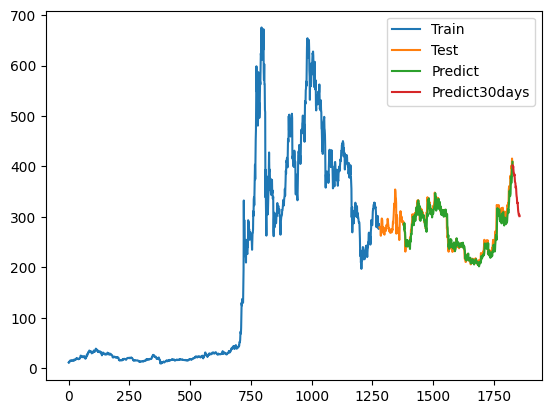

In [113]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_predict))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [114]:
x_input.shape

(1, 100, 1)

In [115]:
train_size_82 = int(0.8 * len(df1))
test_size_82 = len(df1) - train_size_82
train_data_82 = df1[:train_size_82]
test_data_82 = df1[train_size_82:train_size_82+test_size_82]

In [116]:
X_train_82, y_train_82 = create_dataset(train_data_82, time_step)
X_test_82, ytest_82 = create_dataset(test_data_82, time_step)

In [117]:
X_train_82 =X_train_82.reshape(X_train_82.shape[0],X_train_82.shape[1] , 1)
X_test_82 = X_test_82.reshape(X_test_82.shape[0],X_test_82.shape[1] , 1)

In [118]:
model.fit(X_train_82,y_train_82,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 9ms/step - loss: 3.5079e-04
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 3.3682e-04
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 3.9036e-04
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 5.0426e-04
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 3.6912e-04
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 3.1967e-04
Epoch 7/100
22/22 [==============================] - 0s 9ms/step - loss: 3.5378e-04
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 3.1985e-04
Epoch 9/100
22/22 [==============================] - 0s 14ms/step - loss: 3.1424e-04
Epoch 10/100
22/22 [==============================] - 0s 14ms/step - loss: 4.1490e-04
Epoch 11/100
22/22 [==============================] - 0s 14ms/step - loss: 3.7579e-04
Epoch 12/100
22/22 [==============================] - 0s 15ms/step - lo

In [119]:
train_predict_82 = model.predict(X_train_82)
test_predict_82 = model.predict(X_test_82)

9/9 [==============================] - 0s 3ms/step


In [120]:
train_predict_82 = scaler.inverse_transform(train_predict_82)
test_predict_82 = scaler.inverse_transform(test_predict_82)
y_train_82 = scaler.inverse_transform(y_train_82.reshape(-1, 1))
ytest_82 = scaler.inverse_transform(ytest_82.reshape(-1, 1))

In [121]:
train_82_rmse = np.sqrt(np.mean((train_predict_82 - y_train_82)**2))
test_82_rmse = np.sqrt(np.mean((test_predict_82 - ytest_82)**2))
test_82_mape = np.mean(np.abs((ytest_82 - test_predict_82) / ytest_82)) * 100
test_82_mse = np.mean((ytest_82 - test_predict_82)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 8.994041862988299
Test RMSE: 9.93591974859317
Test MAPE: 3.1732656739712906
Test MSE: 98.72250125048376


In [122]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_82[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.33675585 0.33545785 0.33776761 0.3341765  0.32723409 0.3306432
 0.32711594 0.3276278  0.32892126 0.33005469 0.32824974 0.3360497
 0.33299709 0.33024014 0.33557263 0.34448539 0.34276336 0.34571182
 0.35574894 0.36786681 0.36475761 0.36643537 0.35346403 0.35264237
 0.34507417 0.34813608 0.36507858 0.37629004 0.39300811 0.39320309
 0.3932248  0.38320847 0.38674482 0.43270004 0.47169776 0.47158018
 0.45699175 0.46192565 0.45482597 0.4577865  0.45432788 0.46116786
 0.4715817  0.46235201 0.44786031 0.4405003  0.44291643 0.43762707
 0.44381158 0.44922158 0.431105   0.43950489 0.43473831 0.46252757
 0.45901412 0.44979772 0.45611245 0.45762464 0.46161676 0.46365535
 0.44432213 0.43376663 0.42579351 0.42403432 0.43964101 0.44490418
 0.44362965 0.452233   0.4473624  0.436689   0.4364261  0.43789551
 0.43576697 0.44326727 0.43744386 0.44022957 0.44762031 0.46448559
 0.47194532 0.47088212 0.46736066 0.47810221 0.47348508 0.48755948
 0.51827373 0.52754821 0.51556818 0.51072327 0.51391

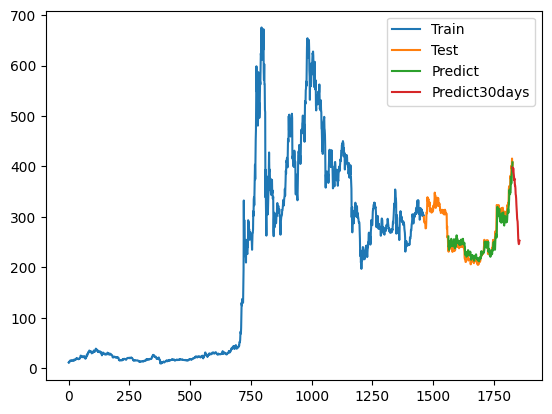

In [123]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_82, step=1)
plt.plot(scaler.inverse_transform(train_data_82))
test_data_index = pd.RangeIndex(start=train_size_82, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_82))
test_data_index = pd.RangeIndex(start=train_size_82+101, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,(test_predict_82))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [124]:
train_size_91 = int(0.9 * len(df1))
test_size_91 = len(df1) - train_size_91
train_data_91 = df1[:train_size_91]
test_data_91 = df1[train_size_91:train_size_91+test_size_91]

In [125]:
X_train_91, y_train_91 = create_dataset(train_data_91, time_step)
X_test_91, ytest_91 = create_dataset(test_data_91, time_step)

In [126]:
X_train_91 =X_train_91.reshape(X_train_91.shape[0],X_train_91.shape[1] , 1)
X_test_91 = X_test_91.reshape(X_test_91.shape[0],X_test_91.shape[1] , 1)

In [127]:
model.fit(X_train_91,y_train_91,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 0s 15ms/step - loss: 3.4764e-04
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 3.9869e-04
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 3.0066e-04
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 2.8329e-04
Epoch 5/100
25/25 [==============================] - 0s 15ms/step - loss: 2.7348e-04
Epoch 6/100
25/25 [==============================] - 0s 15ms/step - loss: 1.9555e-04
Epoch 7/100
25/25 [==============================] - 0s 14ms/step - loss: 2.1203e-04
Epoch 8/100
25/25 [==============================] - 0s 15ms/step - loss: 2.9374e-04
Epoch 9/100
25/25 [==============================] - 0s 14ms/step - loss: 2.4013e-04
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 2.4021e-04
Epoch 11/100
25/25 [==============================] - 0s 8ms/step - loss: 2.6116e-04
Epoch 12/100
25/25 [==============================] - 0s 9ms/ste

In [128]:
train_predict_91 = model.predict(X_train_91)
test_predict_91 = model.predict(X_test_91)

3/3 [==============================] - 0s 5ms/step


In [129]:
train_predict_91 = scaler.inverse_transform(train_predict_91)
test_predict_91 = scaler.inverse_transform(test_predict_91)
y_train_91 = scaler.inverse_transform(y_train_91.reshape(-1, 1))
ytest_91 = scaler.inverse_transform(ytest_91.reshape(-1, 1))

In [130]:
train_91_rmse = np.sqrt(np.mean((train_predict_91 - y_train_91)**2))
test_91_rmse = np.sqrt(np.mean((test_predict_91 - ytest_91)**2))
test_91_mape = np.mean(np.abs((ytest_91 - test_predict_91) / ytest_91)) * 100
test_91_mse = np.mean((ytest_91 - test_predict_91)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 8.994041862988299
Test RMSE: 9.93591974859317
Test MAPE: 3.1732656739712906
Test MSE: 98.72250125048376


In [131]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_91[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.33675585 0.33545785 0.33776761 0.3341765  0.32723409 0.3306432
 0.32711594 0.3276278  0.32892126 0.33005469 0.32824974 0.3360497
 0.33299709 0.33024014 0.33557263 0.34448539 0.34276336 0.34571182
 0.35574894 0.36786681 0.36475761 0.36643537 0.35346403 0.35264237
 0.34507417 0.34813608 0.36507858 0.37629004 0.39300811 0.39320309
 0.3932248  0.38320847 0.38674482 0.43270004 0.47169776 0.47158018
 0.45699175 0.46192565 0.45482597 0.4577865  0.45432788 0.46116786
 0.4715817  0.46235201 0.44786031 0.4405003  0.44291643 0.43762707
 0.44381158 0.44922158 0.431105   0.43950489 0.43473831 0.46252757
 0.45901412 0.44979772 0.45611245 0.45762464 0.46161676 0.46365535
 0.44432213 0.43376663 0.42579351 0.42403432 0.43964101 0.44490418
 0.44362965 0.452233   0.4473624  0.436689   0.4364261  0.43789551
 0.43576697 0.44326727 0.43744386 0.44022957 0.44762031 0.46448559
 0.47194532 0.47088212 0.46736066 0.47810221 0.47348508 0.48755948
 0.51827373 0.52754821 0.51556818 0.51072327 0.51391

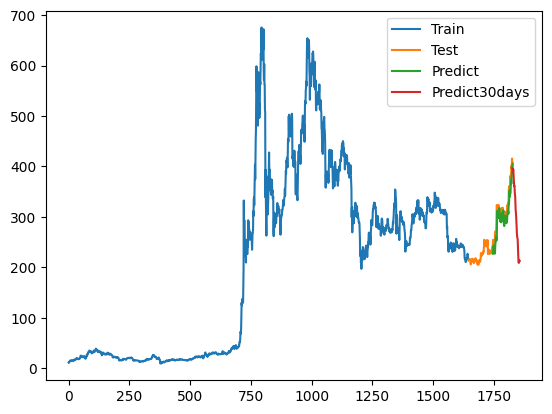

In [133]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_91, step=1)
plt.plot(scaler.inverse_transform(train_data_91))
test_data_index = pd.RangeIndex(start=train_size_91, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_91))
test_data_index = pd.RangeIndex(start=train_size_91+101, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,(test_predict_91))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()